<a href="https://colab.research.google.com/github/A-Kester/csci-451/blob/main/docs/live-notebooks/06-regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Features and Regularization

Our first look at methods for using and controlling model complexity

Suppose that we’d like to model a distinctly *nonlinear* relationship in our data:

Figure 1: Nonlinear data generated from a sinusoidal signal plus Gaussian noise.

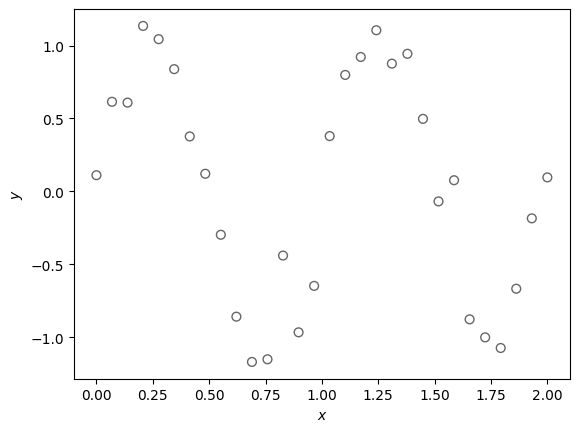

In [1]:
import torch
from matplotlib import pyplot as plt
scatterplot_kwargs = dict(color = "black", label = "data", facecolors = "none", s = 40, alpha = 0.6)

sig = 0.2
X = torch.linspace(0, 2, 30).reshape(-1, 1)

signal = torch.sin(2*torch.pi*X)
noise = sig*torch.randn(X.shape)
y = signal + noise

fig, ax = plt.subplots()
ax.scatter(X.numpy(), y.numpy(), **scatterplot_kwargs)
plt.xlabel(r"$x$")
t = plt.ylabel(r"$y$")

One flexible candidate model for this kind of data is a nonlinear Gaussian model:

<span class="theorem-title">**Definition 1**</span> A **nonlinear Gaussian model** with *mean function $f$* and *variance $\sigma^2$* is a probabilistic model for data $(\mathbf{x}_i, y_i)_{i=1}^n$ such that

$$
\begin{aligned}
    y_i \sim \mathcal{N}(f(\mathbf{x}_i); \sigma^2)\;.
\end{aligned}
$$

That is, each target value $y_i$ has Gaussian distribution with a mean (or signal) given by $f(\mathbf{x}_i)$ and variance (or noise level) $\sigma^2$.

Here’s a visualization of this model with $f(x) = \sin(2\pi x)$ and $\sigma^2 = 0.01$, which was the setting used to generate the synthetic data above:

Figure 2: Data modeled via a nonlinear Gaussian model with mean function $f(x) = \sin(2\pi x)$ and noise level $\sigma = 0.2$. The dashed line indicates the signal function, while the blue curves indicate the conditional distributions of $y$ given $x$. The black circles are the observed data points.

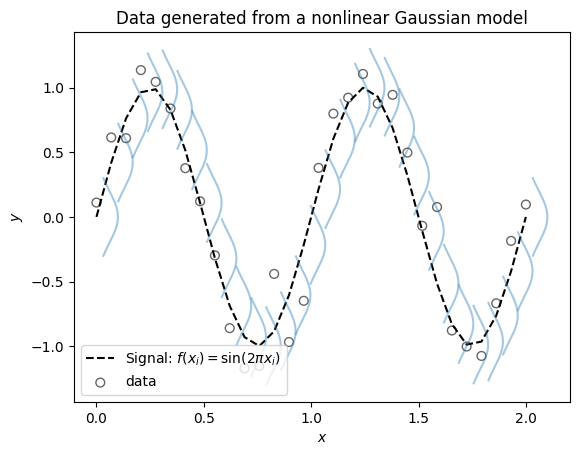

In [2]:
def draw_gaussian_at(support, sd=1.0, height=1.0,
        xpos=0.0, ypos=0.0, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    gaussian = torch.exp((-support ** 2.0) / (2 * sd ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= height
    return ax.plot(gaussian + xpos, support + ypos, **kwargs)

support = torch.linspace(-0.3, 0.3, 1000)
fig, ax = plt.subplots()

ax.plot(X.numpy(), torch.sin(2*torch.pi*X).numpy(), color = "black", linestyle = "--", label = r"Signal: $f(x_i) = \sin(2\pi x_i)$")

for each in X:
    draw_gaussian_at(support, sd=sig, height=0.1, xpos=each, ypos=torch.sin(2*torch.pi*each), ax=ax, color='C0', alpha=0.4)

ax.scatter(X.numpy(), y.numpy(), **scatterplot_kwargs)

plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Data generated from a nonlinear Gaussian model")
plt.legend()
plt.show()

This is all well and good as a theoretical framework, but how in the world were we supposed to know that $f(x) = \sin(2\pi x)$ was the right choice? In practice, of course, we never will.

## Basis Function Expansion

Since we don’t know the right functional form for $f$, one common approach is try to approximate

$$
\begin{aligned}
    f(\mathbf{x}) \approx w_0\phi_0(\mathbf{x}) + w_1 \phi_1(\mathbf{x}) + w_2 \phi_2(\mathbf{x}) + \cdots + w_p \phi_p(\mathbf{x}) = \sum_{j=0}^p w_j \phi_j(\mathbf{x})\;,
\end{aligned}
$$ where $\phi_j(\cdot)$ are a collection of *basis functions* that we choose ahead of time. This is called a **basis function expansion**. $\phi_j$

Before we look at some examples of basis functions, let’s take a look at the fundamental trick behind basis function expansions: when using a basis function expansion with a nonlinear Gaussian model, the model is *linear* in the parameters $w_j$, and we can therefore use our previously-developed machinery for linear regression to fit the model. To see this, note that we can write

$$
\begin{aligned}
    \sum_{j=0}^p w_j \phi_j(\mathbf{x}) = \mathbf{w}^T \mathbf{\phi}(\mathbf{x})\;,
\end{aligned}
$$

where we’ve defined the vector of parameters $\mathbf{w}= (w_0, w_1, \ldots, w_p)^T$ and the vector of basis functions $\mathbf{\phi}(\mathbf{x}) = (\phi_0(\mathbf{x}), \phi_1(\mathbf{x}), \ldots, \phi_p(\mathbf{x}))^T$. Let’s give the shorthand $\hat{y}_i = \mathbf{w}^T \mathbf{\phi}(\mathbf{x}_i)$ for the prediction of the model at input $\mathbf{x}_i$. Then, taken together the nonlinear Gaussian model with basis function expansion says that

$$
\begin{aligned}
    y_i \sim \mathcal{N}(\hat{y}_i; \sigma^2) = \mathcal{N}(\mathbf{w}^T \mathbf{\phi}(\mathbf{x}_i); \sigma^2)\;.
\end{aligned}
$$

This is just like the linear-Gaussian model, but with the input data $\mathbf{x}_i$ replaced by the transformed data $\mathbf{\phi}(\mathbf{x}_i)$. Therefore, we can use our previous results for maximum likelihood estimation of the parameters $\mathbf{w}$ in the linear-Gaussian model, simply by replacing each occurrence of $\mathbf{x}_i$ with $\mathbf{\phi}(\mathbf{x}_i)$. In particular, we can maximize the log-likelihood of the data by minimizing the mean squared error between the predictions $\hat{y}_i$ and the observed targets $y_i$:

$$
\begin{aligned}
    R(\mathbf{X}, \mathbf{y}; \mathbf{w}) = \frac{1}{n} \sum_{i=1}^n (y_i - \mathbf{w}^T \mathbf{\phi}(\mathbf{x}_i))^2\;.
\end{aligned}
$$

If we define

$$
\begin{aligned}
    \mathbf{\Phi}= \left[\begin{matrix}
        - &\mathbf{\phi}(\mathbf{x}_1)^T & -\\
        - &\mathbf{\phi}(\mathbf{x}_2)^T & -\\
        \vdots \\
        - &\mathbf{\phi}(\mathbf{x}_n)^T & -    
    \end{matrix}\right]\;,
\end{aligned}
$$

we can similarly write the mean squared error in matrix form as

$$
\begin{aligned}
    R(\mathbf{\Phi}, \mathbf{y}; \mathbf{w}) = \frac{1}{n} \lVert \mathbf{\Phi}\mathbf{w}- \mathbf{y} \rVert^2\;.
\end{aligned}
$$

So, to learn a model with basis function expansion, all we need to do is construct the feature matrix $\mathbf{\Phi}$ by applying the basis functions to each data point, and then run linear regression as before.

Let’s try basis function expansion on our synthetic data. For this, we’ll first bring in the linear regression model that we developed previously:

In [3]:
class LinearRegression:
    def __init__(self, n_params):
        self.w = torch.zeros(n_params, 1, requires_grad=True)

    def forward(self, X):
        return X @ self.w

We’ll also write a simple training loop, this time using some of PyTorch’s built-in optimization functionality: rather than implement our own `GradientDescentOptimizer` class today, we’ll instead use the `torch.optim.Adam` optimizer. This enables faster training, which will help us for the experiments in these notes.

In [5]:
def mse(y_pred, y):
    return torch.mean((y_pred - y) ** 2)

def train_model(model, X_train, y_train, lr=1e-2, n_epochs=1000, tol=1e-4, regularization = None, verbose = False):
    opt = torch.optim.Adam(params=[model.w], lr=lr) # gradient descent but fancy
    for epoch in range(n_epochs):
        y_pred = model.forward(X_train)
        loss = mse(y_pred, y_train) + (regularization(model.w) if regularization is not None else 0.0)

        opt.zero_grad()
        loss.backward() #<2> automated computation of gradients for Adam optimization
        opt.step() #<3> perform an optimization step
        if model.w.grad is not None:
            if model.w.grad.norm().item() < tol:
                if verbose:
                    print(f"Converged at epoch {epoch}, Loss: {loss.item()}")
                break
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

It’s helpful to think about the minimal linear regression model, in which we simply add a constant column to the data, as an example of a basis function expansion. We’ll call this the *linear* basis function.

In [6]:
def linear_basis_function(X):
    """
    just adds the constant feature
    """
    n_samples = X.shape[0]
    Phi = torch.ones(n_samples, 2)  # intercept + linear term
    Phi[:, 1] = X.flatten()
    return Phi

If we try fitting this model to the sinusoidal data directly, we’ll be disappointed.

In [8]:
PHI = linear_basis_function(X)
LR = LinearRegression(n_params = 2)
train_model(LR, PHI, y, lr = 1e-2, n_epochs = 1000)

In [9]:
# utility function for model visualization
def viz_model_predictions(model, X, y, basis_fun, ax, **basis_fun_kwargs):

    x_new = torch.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
    PHI_new = basis_fun(x_new, **basis_fun_kwargs)
    y_pred = model.forward(PHI_new)
    ax.scatter(X.numpy(), y.numpy(), **scatterplot_kwargs)
    ax.plot(x_new.numpy(), y_pred.detach().numpy(), color='red', label='Prediction')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")

How did we do?

Figure 3: Example of linear regression fit to the sinusoidal data set using the linear (trivial) basis function expansion.

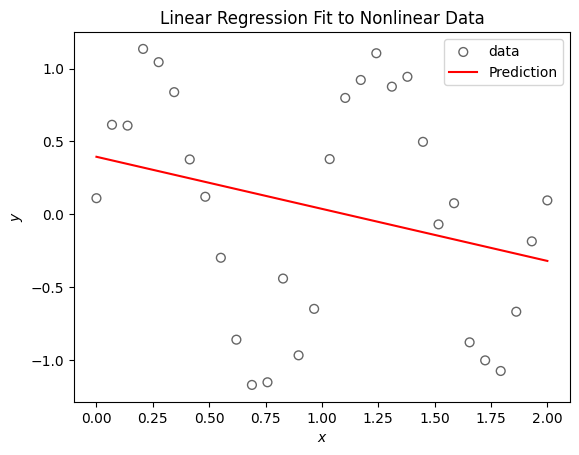

In [10]:
fig, ax = plt.subplots()
viz_model_predictions(LR, X, y, basis_fun = linear_basis_function, ax=ax)
plt.title("Linear Regression Fit to Nonlinear Data")
plt.legend()
plt.show()

Now let’s try some nontrivial basis function expansions. If we had reason to believe that our data was periodic, we might try using sine and cosine basis functions. For example, let’s try:

$$
\begin{aligned}
    \phi_0(x) &= 1\;,\\
    \phi_1(x) &= \sin(\pi x)\;,\\
    \phi_2(x) &= \sin(2 \pi x)\;,\\
    \phi_3(x) &= \sin(3 \pi x)\;,\\
    \vdots
\end{aligned}
$$

The following function constructs the feature matrix $\mathbf{\Phi}$ for this basis function expansion:

In [11]:
def sinusoidal_features(X, max_freq=4):
    n_samples = X.shape[0]
    Phi = torch.ones(n_samples, max_freq + 1)
    for i in range(1, max_freq + 1):
        Phi[:, i] = torch.sin(i * torch.pi * X).flatten()
    return Phi

To train models and make predictions, all we need to do is call this function to get the feature matrix, and then run linear regression as before.

In [13]:
max_freq = 10
PHI = sinusoidal_features(X, max_freq = max_freq)
#PHI.shape # 30 data points, 1 constant column, 10 columns of features?

# train the model
LR = LinearRegression(n_params= PHI.shape[1]) # number of columns of PHI
train_model(LR, PHI, y, lr=1e-2, n_epochs=2000)

Figure 4: Example fit to data using the sinusoidal basis function expansion with maximum frequency 15.

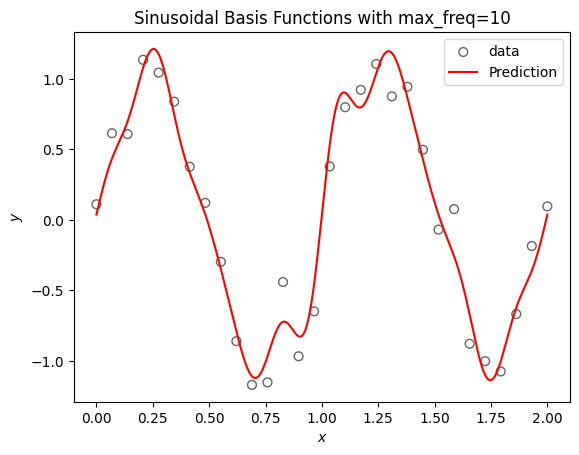

In [14]:
# visualize
fig, ax = plt.subplots()

viz_model_predictions(LR, X, y, basis_fun = sinusoidal_features, ax=ax, max_freq=max_freq)

plt.title(f"Sinusoidal Basis Functions with max_freq={max_freq}")
plt.legend()

Let’s try this for a variety of maximum frequencies.

Figure 5: Example fits to training data using the sinusoidal basis function expansion with varying maximum frequencies.

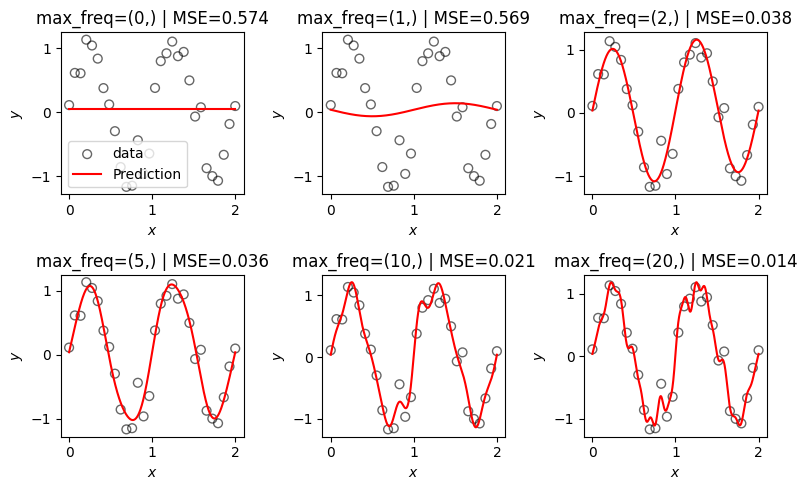

In [15]:
fig, axarr = plt.subplots(2, 3, figsize=(8,5))

max_freqs = [0, 1, 2, 5, 10, 20]

for i, ax in enumerate(axarr.flatten()):

    PHI = sinusoidal_features(X, max_freq=max_freqs[i])
    LR = LinearRegression(n_params=PHI.shape[1])
    train_model(LR, PHI, y, lr=1e-2, n_epochs=2000)

    viz_model_predictions(LR, X, y, basis_fun = sinusoidal_features, ax=ax, max_freq=max_freqs[i])

    mse_val = mse(LR.forward(PHI), y).item()
    ax.set_title(f"max_freq={max_freqs[i], } | MSE={mse_val:.3f}")

    if i == 0:
        ax.legend()
plt.tight_layout()

As the number of basis functions increases, the model becomes more flexible and is able to better fit the training data. However, with too many basis functions, the model begins to overfit the data, capturing noise rather than the underlying signal as reflected in the seemingly random high-frequency oscillations in the predictions.

## Kernel Basis Functions

Another common choice of basis functions are *kernel basis functions*. A kernel is simply a measure of similarity between two inputs. A common choice is the Gaussian radial-basis kernel, which is defined in one dimension by

$$
k(x, c) = \exp\left(-(x - c)^2\right)\;,
$$

The Guassian kernel measures similarity between $x$ and a center point $c$, with values close to 1 when $x$ is near $c$ and values close to 0 when $x$ is far from $c$.

Here’s an implementation in one dimension, where we evenly space choices of $c$ out across the range of the data:

In [16]:
def kernel_features(X, num_kernels):
    n_samples = X.shape[0]
    Phi = torch.ones(n_samples, num_kernels + 1)
    centers = torch.linspace(X.min(), X.max(), num_kernels)
    bandwidth = (X.max() - X.min()) / num_kernels
    for j in range(num_kernels):
        Phi[:, j + 1] = torch.exp(-0.5 * ((X.flatten() - centers[j]) / bandwidth) ** 2)
    return Phi

We can now run the same experiment as before:

Figure 6: Visualization of fits to training data using the kernel basis function expansion with varying numbers of Gaussian radial basis kernels.

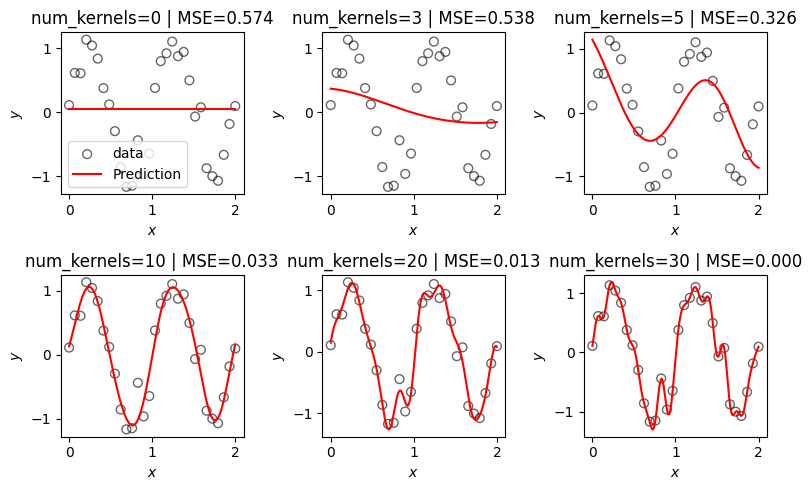

In [17]:
fig, axarr = plt.subplots(2, 3, figsize=(8,5))

num_kernels = [0, 3, 5, 10, 20, 30]

for i, ax in enumerate(axarr.flatten()):

    PHI = kernel_features(X, num_kernels=num_kernels[i])
    LR = LinearRegression(n_params=PHI.shape[1])
    train_model(LR, PHI, y, lr=1e-2, n_epochs=200000, tol = 1e-4)

    viz_model_predictions(LR, X, y, basis_fun = kernel_features, ax=ax, num_kernels=num_kernels[i])

    mse_val = mse(LR.forward(PHI), y).item()
    ax.set_title(f"num_kernels={num_kernels[i]} | MSE={mse_val:.3f}")

    if i == 0:
        ax.legend()
plt.tight_layout()

As before, we observe that as the number of basis functions increases, the model becomes more flexible and is able to better fit the training data, but eventually begins to overfit.

## Regularization

We now find ourselves in a bit of a dilemma – we’d like to use flexible models with many basis functions to capture nonlinear patterns in data, but introducing flexibility raises the risk of overfitting. One approach is to simply restrict which basis functions we’ll use, but this is unsatisfying: how will we know ahead of time which basis functions are best?

An alternative approach is to use **regularization**. Regularization works by encouraging our models to maintain small entries in the parameter vector $\mathbf{w}$. This effectively allows us to use many basis functions, but penalizes the model for emphasizing any one of them too heavily.

Typical regularization schemes work by adding a penalty term to the loss function (e.g. the MSE). For example, in *ridge regression*, we add a penalty proportional to the squared $\ell_2$ norm of the parameter vector:

$$
\begin{aligned}
    \hat{\mathbf{w}} = \mathop{\mathrm{arg\,min}}_\mathbf{w}\left\{ \frac{1}{n} \lVert \mathbf{\Phi}\mathbf{w}- \mathbf{y} \rVert^2 + \lambda \lVert \mathbf{w} \rVert^2 \right\}\;,
\end{aligned}
$$

where $\lambda$ is a hyperparameter that controls the strength of the regularization. Larger values of $\lambda$ encourage smaller parameter values, while smaller values allow the model to fit the data more closely.

We can implement ridge regression by adding an $\ell_2$ regularization term to our training loop. We’ll first just implement that term itself:

In [20]:
def ell_2_regularization(w):
  return torch.mean(w[1:]**2) # exclude first entry of w

The reason for excluding the first entry of $w$ from the regularization term is that this entry corresponds to the intercept term, which we typically don’t want to penalize. We then pass this function in to the `regularization` argument of `train_model`, where flagged line \<1\> adds the regularization term to the loss. We train again and visualize the results as we vary the regularization strength, this time keeping the maximum frequency of the sinusoidal basis functions fixed at 20:

Figure 7: Ridge regression models using sinusoidal basis functions with maximum frequency 20, for varying regularization strengths, visualized against training data.

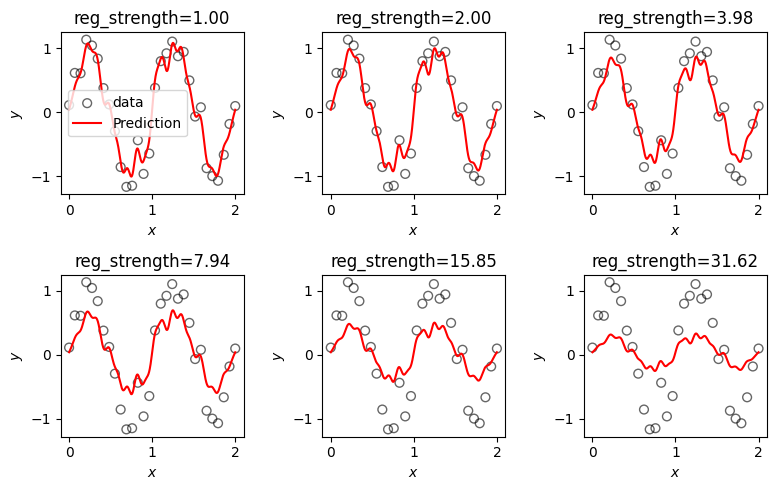

In [19]:
fig, axarr = plt.subplots(2, 3, figsize=(8,5))
reg_strengths = torch.logspace(0, 1.5, 6)

for i, ax in enumerate(axarr.flatten()):

    PHI = sinusoidal_features(X, max_freq=20)
    LR = LinearRegression(n_params=PHI.shape[1])
    train_model(LR, PHI, y, lr=1e-2, n_epochs=200000, tol = 1e-4, regularization = lambda w: reg_strengths[i]*ell_2_regularization(w))
    viz_model_predictions(LR, X, y, basis_fun = sinusoidal_features, ax=ax, max_freq=20)

    ax.set_title(f"reg_strength={reg_strengths[i]:.2f}")
    if i == 0:
        ax.legend()
plt.tight_layout()

We observe that the tendency of $\ell_2$ regularization in this setting is to “shrink” the coefficients of the basis functions toward zero. This makes the predictions somewhat smoother, but also just makes them *smaller*, eventually leaving them systematically smaller than the data in magnitude.

An alternative regularization is $\ell_1$ regularization, in which we penalize the absolute values of the parameters rather than their squares. This gives us a version of regression commonly called *lasso regression*:

$$
\begin{aligned}
    \hat{\mathbf{w}} = \mathop{\mathrm{arg\,min}}_\mathbf{w}\left\{ \frac{1}{n} \lVert \mathbf{\Phi}\mathbf{w}- \mathbf{y} \rVert^2 + \lambda \sum_{j=1}^p |w_j| \right\}\;.
\end{aligned}
$$

We can implement $\ell_1$ regularization similarly to before:

In [23]:
def ell_1_regularization(w): # more computationally expensive
    return torch.mean(torch.abs(w[1:]))  # exclude intercept from regularization

Now we can run the same experiment:

Figure 8: LASSO regression models using sinusoidal basis functions with maximum frequency 20, for varying regularization strengths, visualized against training data.

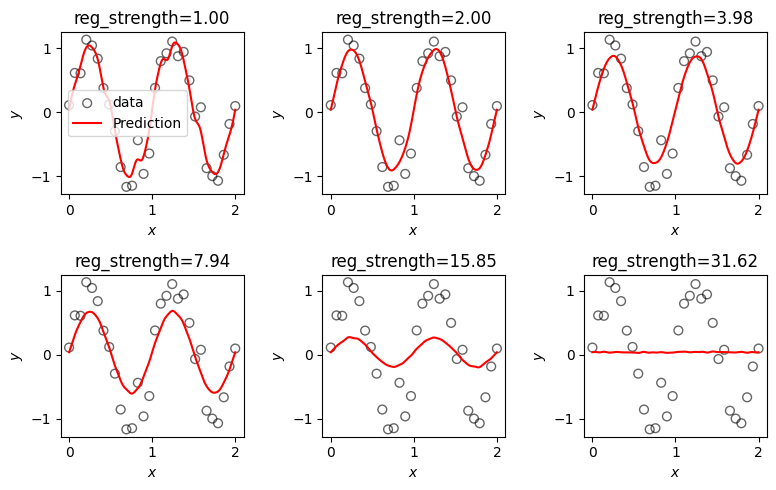

In [24]:
fig, axarr = plt.subplots(2, 3, figsize=(8,5))
reg_strengths = torch.logspace(0, 1.5, 6)

for i, ax in enumerate(axarr.flatten()):

    PHI = sinusoidal_features(X, max_freq=20)
    LR = LinearRegression(n_params=PHI.shape[1])
    train_model(LR, PHI, y, lr=1e-2, n_epochs=20000, tol = 1e-4, regularization = lambda w: reg_strengths[i]*ell_1_regularization(w))
    viz_model_predictions(LR, X, y, basis_fun = sinusoidal_features, ax=ax, max_freq=20)

    ax.set_title(f"reg_strength={reg_strengths[i]:.2f}")
    if i == 0:
        ax.legend()
plt.tight_layout()

LASSO is somewhat more difficult to fit in computational terms, resulting in longer computation times. We observe that some of the LASSO fits manage to highlight the underlying trend in the data relatively well, with somewhat less systematic underfitting when compared to the ridge regression fits.

An important and useful property of LASSO is that it tends to set many of the coefficients exactly to zero, effectively performing *feature selection*.<span class="column-margin margin-aside">Features with coefficients of 0 are effectively thrown away from the model.</span> This can be useful when we have a large number of basis functions, as it allows us to identify which ones are most important for modeling the data. Let’s take a look at the coefficients learned by a LASSO model with moderate regularization strength:

Figure 9: Visualization of the coefficients learned by LASSO regression. Coefficients less than $0.01$ have been highlighted in white. Given a more efficient optimizer, LASSO regression would set these coefficients to exactly 0.

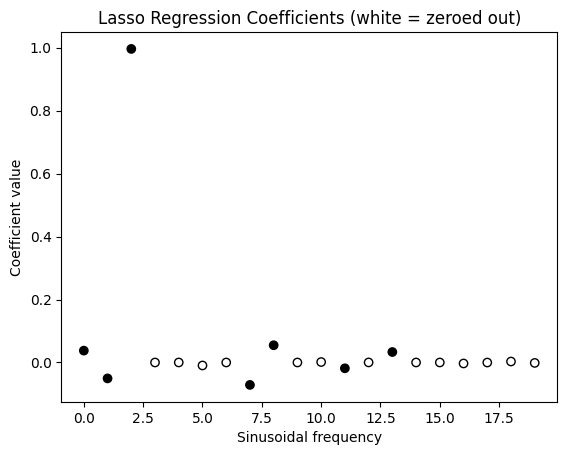

In [25]:
LR = LinearRegression(n_params=PHI.shape[1])
train_model(LR, PHI, y, lr=1e-4, n_epochs=50000, tol = 1e-4, regularization = lambda w: 1.0*ell_1_regularization(w))

freqs = range(PHI.shape[1]-1)

zeros = torch.abs(LR.w) <= 1e-2

fig, ax = plt.subplots()
ax.scatter(freqs, LR.w.detach().numpy()[:-1], c = zeros.numpy()[:-1], cmap='Greys_r', edgecolors='black')

ax.set_xlabel("Sinusoidal frequency")
ax.set_ylabel("Coefficient value")
t = plt.title("Lasso Regression Coefficients (white = zeroed out)")

## Model Selection

In one way, we’ve just kicked the can down the road – in an environment in which we can’t visually inspect the data or model predictions, how are we supposed to know what features or what regularization strength to use?

This is an instance of a problem called *model selection*, which asks us to make choices between models containing different features or hyperparameters. A very common approach to model selection is to use a *validation set*. The idea is to split our data into three parts: a training set which we’ll use for actually training our models, a validation set which we’ll use for model selection, and a test set which we’ll use for final evaluation of our chosen model. So, to make choices about the regularization strength, for example, we’ll train separate models with different regularization strengths on the training set, and then evaluate their performance on the validation set. The model with the best validation performance is then selected as the final model.

### Features In the Wild

Although in the previous examples we engineered our features by hand using basis-function expansions, features are also natural parts of data sets! Often the data set we want to predict already has all the features we need (or more!), and we need to make all the same choices about which features to use and how to regularize. In the case study below, we’ll face some of these same questions without needing to engineer any new features by hand.

### Bike Share Case Study

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from matplotlib import pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/PhilChodrow/ml-notes-update/refs/heads/main/data/bikeshare/hour.csv')

We’ve downloaded a data set containing hourly bike rental counts in Washington, D.C., along with a variety of features that might be predictive of bike rental demand. <span class="column-margin margin-aside">This data set was collected by Fanaee-T and Gama (2013).</span> The data contains a variety of features including weather conditions, the year, month, week, and weekday; the hour of the day. It also includes columns for the number of casual and registered users, as well as the total count of bike rentals (`cnt`). We’ll try to predict the total count of bike rentals using the other features. Let’s take a look:

In [ ]:
df.head()

Our aim is to predict the `cnt` column using the other features. Let’s visualize the total number of bike rentals over time:

Figure 10: Daily ridership in the bikeshare data set.

In [ ]:
fig, ax = plt.subplots(figsize = (6, 4))
ridership_by_day = df.groupby("dteday")["cnt"].sum().reset_index()
ridership_by_day["dteday"] = pd.to_datetime(ridership_by_day["dteday"])

ax.plot(ridership_by_day["dteday"], ridership_by_day["cnt"], color='steelblue')

plt.xlabel("Date")
t = plt.ylabel("Total Daily Bike Rentals")

Predicting the number of bike rentals on a given day is a very helpful task for bikeshare operators, as this can help them know the urgency of rebalancing (moving bikes between stations) and scheduling maintenance.

Let’s prepare our data for modeling by dropping some columns and transforming qualitative columns into one-hot encoded features:

In [ ]:
df.drop(columns=['instant', 'dteday', "workingday"], inplace=True)

df = 1.0*pd.get_dummies(df, columns=['season', 'weathersit', 'mnth', 'hr', 'weekday'], drop_first=False)

# ensure that the constant feature is the first column
df["intercept"] = 1
cols = list(df.columns)
cols.insert(0, cols.pop(cols.index('intercept')))
df = df.loc[:,cols]
df.columns

We’ll now split the data into features and targets, and then into training, validation, and test sets.

In [ ]:
X = 1.0*df.drop(columns=['cnt', 'casual', 'registered'])
y = df['cnt']

test_proportion = 0.94

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proportion, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/2, random_state=42)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_val   = torch.tensor(X_val.values, dtype=torch.float32)
y_val   = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32)
X_test  = torch.tensor(X_test.values, dtype=torch.float32)
y_test  = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

We’ve split the data into three pieces: a small training set (3% of the data), a validation set (3% of the data), and a test set (94% of the data). Given the size of the data set, this split is reasonable – we have enough data to train models effectively, while still leaving a large amount of data for final evaluation.

In [ ]:
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

> **Why so few training samples?**
>
> Issues related to feature engineering and regularization most frequently arise in settings where we many *parameters* and relatively few *data points*. Therefore, to illustrate these issues clearly, we’ve deliberately limited the size of the training set. In practice, of course, one would typically want to use as much data as possible for training.
>
> Although this example is a bit artificial, modern neural networks are often trained with vastly more parameters than data points, making these considerations quite relevant in practice.

To contextualize model performance on real data, it’s helpful to compute a *base rate*.

<span class="theorem-title">**Definition 2 (Base Rate)**</span> A *base rate* is a measure of performance for a model which uses *no features* in the data. We typically say that a model has demonstrated success in learning from features if it outperforms the base rate on unseen data.

Let’s check the base rate for the bikeshare data and assess on validation data:

In [ ]:
# TODO
print(f"Base rate MSE on validation data: {base_rate_mse.item():.4f}")

So, we are looking for any reasonable candidate model to achieve validation MSE less than the above.

In principle, we can already go ahead and fit a model:

In [ ]:
LR = LinearRegression(n_params=X_train.shape[1])
train_model(LR, X_train, y_train, lr=1e-2, n_epochs=50000, tol=1e-4)
y_pred = LR.forward(X_val)
val_mse = mse(y_pred, y_val)
print(f"Validation MSE without regularization: {val_mse.item():.4f}")
print(f"Fraction of base rate: {val_mse.item()/base_rate_mse.item():.4f}")

This simple linear regression model with no regularization already performs considerably better on validation data than the base rate. Can we do better with regularization? To find out, we’ll do a systematic search in which we vary the regularization strength and evaluate performance on validation data, for each of ridge regression and LASSO.

Figure 11: Model selection in ridge regression on the bikeshare data set. (Left): training and validation MSE as a function of regularization strength. (Right): learned weights as a function of regularization strength.

In [ ]:
reg_strengths = torch.logspace(-5, 0, 21)

train_mses = []
val_mses = []

W = torch.empty(X_train.shape[1], 0)

for reg in reg_strengths:

    LR = LinearRegression(n_params=X_train.shape[1])
    train_model(LR, X_train, y_train, lr=1e-1, n_epochs=20000, tol = 1e-2, regularization = lambda w: reg*ell_2_regularization(w))

    y_pred_train = LR.forward(X_train)
    train_mse = mse(y_pred_train, y_train)
    y_pred_val = LR.forward(X_val)
    val_mse = mse(y_pred_val, y_val)

    train_mses.append(train_mse.item())
    val_mses.append(val_mse.item())

    W = torch.cat((W, LR.w), dim=1)

best_reg = reg_strengths[val_mses.index(min(val_mses))]

fig, ax = plt.subplots(1, 2, figsize = (8,3))
ax[0].plot(reg_strengths, train_mses, label='Train MSE')
ax[0].plot(reg_strengths, val_mses, label='Validation MSE')

ax[0].axvline(best_reg, color='black', linestyle='--', label=fr'Best $\lambda=${best_reg:.2f}, val MSE {min(val_mses):.1f}')


ax[0].set_xlabel("Regularization Strength")
ax[0].set_ylabel("MSE")
ax[0].set_xscale("log")
plt.title("Ridge Regression: Train and Validation MSE vs Regularization Strength")
ax[0].legend()

ax[1].plot(reg_strengths, W.detach().numpy().T)
ax[1].axvline(best_reg, color='black', linestyle='--', label=f'Best reg={best_reg:.4f}')
ax[1].set_xlabel("Regularization Strength")
ax[1].set_ylabel("Weights")
ax[1].set_xscale("log")
plt.title("Ridge Regression: Weights vs Regularization Strength")

plt.tight_layout()

Now let’s try the same experiment for LASSO.

Figure 12: Model selection in LASSO regression on the bikeshare data set. (Left): training and validation MSE as a function of regularization strength. (Right): learned weights as a function of regularization strength.

In [ ]:
reg_strengths = torch.logspace(0, 2, 21)

train_mses = []
val_mses = []

W = torch.empty(X_train.shape[1], 0)

for reg in reg_strengths:

    LR = LinearRegression(n_params=X_train.shape[1])
    train_model(LR, X_train, y_train, lr=1e-2, n_epochs=50000, tol = 1e-2, regularization = lambda w: reg*ell_1_regularization(w))

    y_pred_train = LR.forward(X_train)
    train_mse = mse(y_pred_train, y_train)
    y_pred_val = LR.forward(X_val)
    val_mse = mse(y_pred_val, y_val)

    train_mses.append(train_mse.item())
    val_mses.append(val_mse.item())

    W = torch.cat((W, LR.w), dim=1)

best_reg = reg_strengths[val_mses.index(min(val_mses))]

fig, ax = plt.subplots(1, 2, figsize = (8,3))
ax[0].plot(reg_strengths, train_mses, label='Train MSE')
ax[0].plot(reg_strengths, val_mses, label='Validation MSE')

ax[0].axvline(best_reg, color='black', linestyle='--', label=fr'Best $\lambda=${best_reg:.2f}, val MSE {min(val_mses):.1f}')


ax[0].set_xlabel("Regularization Strength")
ax[0].set_ylabel("MSE")
ax[0].set_xscale("log")
plt.title("LASSO Regression: Train and Validation MSE vs Regularization Strength")
ax[0].legend()

ax[1].plot(reg_strengths, W.detach().numpy().T)
ax[1].axvline(best_reg, color='black', linestyle='--', label=f'Best reg={best_reg:.4f}')
ax[1].set_xlabel("Regularization Strength")
ax[1].set_ylabel("Weights")
ax[1].set_xscale("log")
plt.title("LASSO Regression: Weights vs Regularization Strength")

plt.tight_layout()

We find that LASSO regression achieves a slightly lower MSE on validation data than ridge regression.

Let’s train the LASSO model one last time with the best regularization strength and take a look at the learned coefficients:

In [ ]:
reg_strength = reg_strengths[val_mses.index(min(val_mses))]
LR = LinearRegression(n_params=X_train.shape[1])
train_model(LR, X_train, y_train, lr=1e-1, n_epochs=20000, tol = 1e-4, regularization = lambda w: reg_strength*ell_1_regularization(w))

We can inspect the coefficients to see which features the model found most important:

In [ ]:
coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': LR.w.detach().numpy().flatten()
}).sort_values(by='Coefficient', key=abs, ascending=False)
coefs.head()

We see that rush hours and high temperatures are identified by the model as highly predictive of bike rental demand.

Finally, let’s evaluate our chosen model on the test set to get a final estimate of performance:

In [ ]:
y_pred_test = LR.forward(X_test)
test_mse = mse(y_pred_test, y_test)
print(f"Test MSE: {test_mse.item():.4f}")
print(f"Fraction of base rate: {test_mse.item()/base_rate_mse.item():.4f}")

Our final model achieves a test MSE considerably lower than the base rate, suggesting that it has successfully learned to predict bike rental demand using the available features.

## References

Fanaee-T, Hadi, and Joao Gama. 2013. “Event Labeling Combining Ensemble Detectors and Background Knowledge.” *Progress in Artificial Intelligence*, 1–15. <https://doi.org/10.1007/s13748-013-0040-3>.